In [1]:
!pip install plotly
!pip install chart_studio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sklearn
import seaborn as sns
from keras.models import Sequential
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode
import plotly.express as px
from plotly.subplots  import make_subplots
import chart_studio.plotly as py
from chart_studio.plotly import iplot
import plotly.graph_objects as go
from plotly.offline import iplot
from keras import optimizers
from datetime import date
import datetime as dt
from datetime import date

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=8917be8fee98cd1ee170ef495d4541d36cddaf50583e5f5ace26e611d45fb33a
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
stock_symbol = 'ITC.NS'
df = pd.read_csv("ITC.NS.csv")

In [3]:
data = df.dropna()

In [4]:
len(data)


1236

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 0 to 1235
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1236 non-null   object 
 1   Open       1236 non-null   float64
 2   High       1236 non-null   float64
 3   Low        1236 non-null   float64
 4   Close      1236 non-null   float64
 5   Adj Close  1236 non-null   float64
 6   Volume     1236 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 77.2+ KB


In [6]:
data.describe

<bound method NDFrame.describe of             Date        Open        High         Low       Close   Adj Close  \
0     2017-07-25  295.000000  295.149994  290.850006  291.399994  242.203461   
1     2017-07-26  292.000000  294.250000  291.500000  293.649994  244.073593   
2     2017-07-27  294.700012  295.399994  286.750000  288.549988  239.834579   
3     2017-07-28  294.299988  294.750000  287.149994  291.549988  242.328125   
4     2017-07-31  289.500000  290.299988  284.500000  285.250000  237.091721   
...          ...         ...         ...         ...         ...         ...   
1231  2022-07-18  295.000000  296.299988  293.750000  295.299988  295.299988   
1232  2022-07-19  295.000000  295.600006  292.700012  294.600006  294.600006   
1233  2022-07-20  294.899994  299.500000  293.600006  298.200012  298.200012   
1234  2022-07-21  299.000000  302.200012  298.000000  299.549988  299.549988   
1235  2022-07-22  300.000000  302.500000  298.100006  300.549988  300.549988   

     

In [7]:
cls = data[['Close']]


In [8]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=('Date', 'Close'),
                    row_heights=[0.2,0.7]
                   )

fig.add_trace(go.Candlestick(x= data.index, open=data['Open'], high=data['High'], low = data['Low'], close=data['Close'], name='OHLC'))




In [9]:
trace1 = go.Scatter(
                    x = data.index,
                    y = data.Close,
                    mode = "lines",
                    name = "Close",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
                    )

d1 = [trace1]
layout = dict(title = 'Close values',
              xaxis= dict(title= 'Close',ticklen= 5,zeroline= False)
             )
fig = dict(data = d1, layout = layout)
iplot(fig)


In [10]:
ds = cls.values
ds

array([[291.399994],
       [293.649994],
       [288.549988],
       ...,
       [298.200012],
       [299.549988],
       [300.549988]])

In [11]:
#normalizing the data
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [12]:
#splittimg the data into training and testing data

train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [13]:
train_size,test_size


(865, 371)

In [14]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]


In [15]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [16]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [17]:
X_train.shape,y_train.shape


((764, 100), (764,))

In [18]:
X_test.shape, y_test.shape


((270, 100), (270,))

In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 14s 621ms/step - loss: 0.0887 - val_loss: 0.0085
Epoch 2/100
12/12 [==============================] - 5s 461ms/step - loss: 0.0173 - val_loss: 0.0118
Epoch 3/100
12/12 [==============================] - 5s 417ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 4/100
12/12 [==============================] - 5s 456ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 5/100
12/12 [==============================] - 5s 458ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 6/100
12/12 [==============================] - 5s 411ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 7/100
12/12 [==============================] - 5s 405ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 4s 317ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 9/100
12/12 [==============================] - 2s 207ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 10/100
12/12 [==============================] - 3s 212ms/step - loss: 0.0036 - val_l

In [22]:
loss = model.history.history['loss']
trace2 = go.Scatter(
                    x = loss,
                    
                    mode = "lines",
                    name = "loss",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)')
                    )


d2 = [trace2]
layout = dict(title = 'loss',
              xaxis= dict(title= 'loss',ticklen= 5,zeroline= False)
             )
fig = dict(data = d2, layout = layout)
iplot(fig)

In [23]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [24]:
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)
invds = normalizer.inverse_transform(ds_scaled)

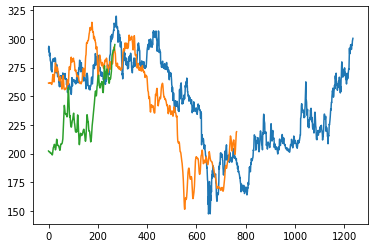

In [25]:

plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [26]:
test = np.vstack((train_predict,test_predict))


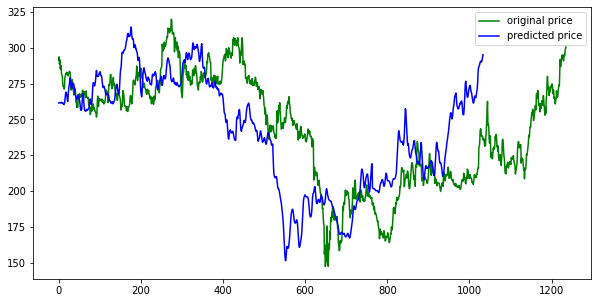

In [27]:

plt.figure(figsize = (10,5))

plt.plot(normalizer.inverse_transform(ds_scaled), 'g', label = 'original price')
plt.plot((test), 'b', label = 'predicted price')

plt.legend()

plt.show()

In [28]:
len(ds_test)


371

In [29]:
fut_inp = ds_test[271:]


In [30]:
fut_inp = fut_inp.reshape(1,-1)


In [31]:
tmp_inp = list(fut_inp)


In [32]:
fut_inp.shape


(1, 100)

In [33]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [34]:
#Predicting next 10 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

    
print(lst_output)

[[0.8764044642448425], [0.8745306730270386], [0.8683185577392578], [0.8608913421630859], [0.8533390760421753], [0.8461411595344543], [0.8395516872406006], [0.8336467146873474], [0.8283505439758301], [0.8234851360321045]]


In [35]:
scale=sklearn.preprocessing.MinMaxScaler()

len(ds_scaled)

1236

In [36]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,111)

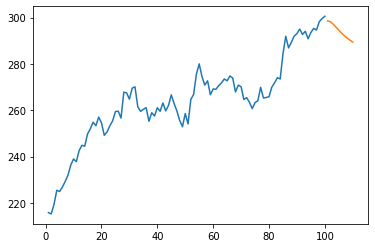

In [37]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1136
                                                          :]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [38]:
ds_new = ds_scaled.tolist()


In [39]:
len(ds_new)


1236

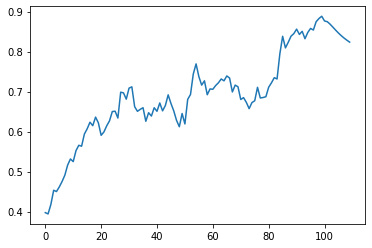

In [40]:
ds_new.extend(lst_output)
plt.plot(ds_new[1136:])

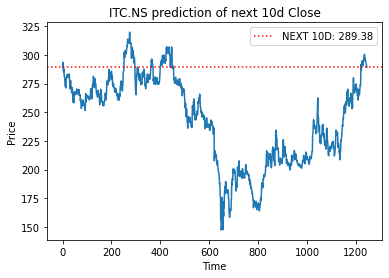

In [41]:
final_graph = normalizer.inverse_transform(ds_new).tolist()
#Plotting final results with predicted value after 10 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next 10d Close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 10D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [42]:
forecast = normalizer.inverse_transform(lst_output)
print(forecast)

[[298.51741579]
 [298.19399941]
 [297.12178828]
 [295.83985082]
 [294.53632964]
 [293.29396921]
 [292.15662626]
 [291.13742796]
 [290.22330886]
 [289.38353942]]


In [43]:
model.save('Keras.h8')

INFO:tensorflow:Assets written to: Keras.h8/assets


INFO:tensorflow:Assets written to: Keras.h8/assets
